In [1]:
# Kusama/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591
# Bitcoin/USD daily (01/01/2021 - 09/09/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1609459200&to=1631189591

# Kusama/USD hourly (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/kusama/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400
# Bitcoin/USD daily (26/03/2021 - 23/06/2021): https://api.coingecko.com/api/v3/coins/bitcoin/market_chart/range?vs_currency=usd&from=1616716800&to=1624406400

SIMULATED_SCENARIOS = 10000
DEBT_CEILING_USD = 20_000_000
# premium redeem is skipped
PREMIUM_REDEEM_BONUS = 0.05
SECURE_THRESHOLD = 1.6
LIQUIDATION_THRESHOLD = 1.25
PREDICTED_DAYS = 100

# Value At Risk (VAR) Model
https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote7.pdf

In [2]:
import json
from statistics import mean
from scipy.stats import pearsonr

def get_usd_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    return [price for (timestamp, price) in data["prices"]]

def get_volume_timeseries(file):
    f = open(file)
    data = json.load(f)
    f.close()
    prices = get_usd_timeseries(file)
    volumes = []
    for i in range(len(data["total_volumes"])):
        (timestamp, usd_volume) = data["total_volumes"][i]
        volumes.append(usd_volume / prices[i])
    return volumes

def determine_price_between_assets(asset_1_prices, asset_2_prices):
    return [asset_1_price / asset_2_price for (asset_1_price, asset_2_price) in zip(asset_1_prices, asset_2_prices)]

def prices_to_returns(prices):
    return [(prices[i]/prices[i - 1] - 1) for i in range(1, len(prices))]
  
kusama_to_usd_hourly = get_usd_timeseries("kusama_to_usd_hourly_Mar_Jun.json")
bitcoin_to_usd_hourly = get_usd_timeseries("bitcoin_to_usd_hourly_Mar_Jun.json")
ksm_to_btc_hourly = determine_price_between_assets(kusama_to_usd_hourly, bitcoin_to_usd_hourly)
ksm_to_btc_returns_hourly = prices_to_returns(ksm_to_btc_hourly)

kusama_to_usd_daily = get_usd_timeseries("kusama_to_usd_daily_2021.json")
ksm_usd_returns_daily = prices_to_returns(kusama_to_usd_daily)

bitcoin_to_usd_daily = get_usd_timeseries("bitcoin_to_usd_daily_2021.json")
btc_usd_returns_daily = prices_to_returns(bitcoin_to_usd_daily)

ksm_to_btc_daily = determine_price_between_assets(kusama_to_usd_daily, bitcoin_to_usd_daily)
ksm_to_btc_returns_daily = prices_to_returns(ksm_to_btc_daily)

ksm_btc_corr, _ = pearsonr(ksm_usd_returns_daily, btc_usd_returns_daily)

ksm_daily_volumes = get_volume_timeseries("kusama_to_usd_daily_2021.json")
btc_daily_volumes = get_volume_timeseries("bitcoin_to_usd_daily_2021.json")
ksm_avg_daily_liquidity = mean(ksm_daily_volumes)
btc_avg_daily_liquidity = mean(btc_daily_volumes)

print('Correlation is: ' + str(ksm_btc_corr))

Correlation is: 0.585108270360336


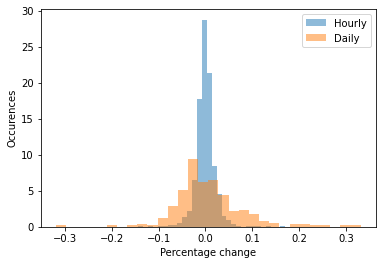

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_returns(returns, data_label):
    plt.hist(returns, density=True, bins=30, alpha=0.5, label=data_label)  # density=False would make counts
    plt.ylabel('Occurences')
    plt.xlabel('Percentage change')
    plt.legend(loc='upper right')

plot_returns(ksm_to_btc_returns_hourly, 'Hourly')
plot_returns(ksm_to_btc_returns_daily, 'Daily')

In [4]:
import statistics
confidence_99 = 2.33
confidence_95 = 1.64
# Compute stddev using the daily returns, as these have higher volatility
# VaR occasionally underestimates the number of large market moves.
# Could consider a higher confidence interval to be on the safe side
std_dev = statistics.pstdev(ksm_to_btc_returns_daily)
expected_loss_percentage_99 = confidence_99 * std_dev
expected_loss_percentage_95 = confidence_95 * std_dev
print("99% confidence interval max price drop (%): " + str(expected_loss_percentage_99 * 100))
required_collateralization_99 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_99)
required_collateralization_95 = LIQUIDATION_THRESHOLD / (1 - expected_loss_percentage_95)
print("Liquidation threshold assumption: " + str(LIQUIDATION_THRESHOLD))
print("Required collateralization (99% confidence interval): " + str(required_collateralization_99))
print("Required collateralization (95% confidence interval): " + str(required_collateralization_95))


99% confidence interval max price drop (%): 17.024958983377694
Liquidation threshold assumption: 1.25
Required collateralization (99% confidence interval): 1.5064771100861387
Required collateralization (95% confidence interval): 1.4201839509072898


# Monte Carlo Simulation
https://arxiv.org/pdf/2002.08099.pdf

Independently simulates the prices of KSM/USD and BTC/USD.

Selects the worst KSM/USD price trajectory, then picks the BTC/USD price trajectory that has the closest pearson correlation to the one in the real data sample.

All vaults considered a single entity, but they are separated from the liquidation vault. When vaults become undercollateralized, liquidators acquire as much liquidity as possible within the constraints, to arbitrage. The assumed available liquidity for both KSM and BTC is the mean traded volumes. Both are required, because liquidators are assumed ot start up their own vault before liquidating.

In the current model, daily liquidity is assumed to be constant. 

In [5]:
# Monte Carlo price simulation (Geometric Brownian Motion)
# Reference article: https://towardsdatascience.com/simulating-stock-prices-in-python-using-geometric-brownian-motion-8dfd6e8c6b18
import pandas as pd

def simulate_and_plot(returns, initial_price, prediction_days, scenario_count):    
    So = initial_price
    dt = 1
    T = prediction_days
    N = T / dt
    t = np.arange(1, int(N) + 1)
    mu = np.mean(returns)
    sigma = np.std(returns)
    scen_size = scenario_count
    b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
    W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}

    # Calculating drift and diffusion components
    drift = (mu - 0.5 * sigma**2) * t
    diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

    # Making the predictions
    S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)]) 
    S = np.hstack((np.array([[So] for scen in range(scen_size)]), S)) # add So to the beginning series

    # Plotting the simulations
#     plt.figure(figsize = (20,10))
#     for i in range(scen_size):
#         plt.title("Daily Volatility: " + str(sigma))
#         plt.plot(S[i, :])
#         plt.ylabel('Price')
#         plt.xlabel('Prediction Days')
#     plt.show()
    return S

def get_worst_price_trajectory(S):
    min_price = S[0, -1]
    index = 0
    for i in range(len(S)):
        if S[i, -1] < min_price:
            min_price = S[i, -1]
            index = i
    return S[index, :]

def get_trajectory_with_closest_correlation(S, base_trajectory, corr):
    picked_trajectory = S[0, :]
    index = 0
    closest_found_correlation, _ = pearsonr(base_trajectory, S[0, :])
    for i in range(len(S)):
        tmp_corr, _ = pearsonr(base_trajectory, S[i, :])
        if abs(tmp_corr - corr) < abs(closest_found_correlation - corr):
            closest_found_correlation = tmp_corr
            picked_trajectory = S[i, :]
            index = i
    return S[index, :], closest_found_correlation

ksm_price_simulations = simulate_and_plot(ksm_usd_returns_daily, kusama_to_usd_daily[0], PREDICTED_DAYS, SIMULATED_SCENARIOS)
worst_ksm_price_trajectory = get_worst_price_trajectory(ksm_price_simulations)
btc_price_simulations = simulate_and_plot(btc_usd_returns_daily, bitcoin_to_usd_daily[0], PREDICTED_DAYS, SIMULATED_SCENARIOS)

correlated_btc_price_trajectory, closest_found_correlation = get_trajectory_with_closest_correlation(btc_price_simulations, worst_ksm_price_trajectory, ksm_btc_corr)
print("selected btc price trajectory with correlation: " + str(closest_found_correlation))
print("observed real correlation: " + str(ksm_btc_corr))

selected btc price trajectory with correlation: 0.5847624436880984
observed real correlation: 0.585108270360336


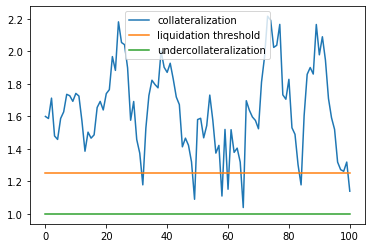

In [6]:
starting_ksm_price = worst_ksm_price_trajectory[0]
starting_btc_price = correlated_btc_price_trajectory[0]
vaults_issued = (DEBT_CEILING_USD / SECURE_THRESHOLD) / starting_btc_price
vaults_ksm_collateral = DEBT_CEILING_USD / starting_ksm_price

liquidation_vault_issued = 0
liquidation_vault_ksm_collateral = 0
current_ksm_btc_price = starting_ksm_price / starting_btc_price

system_ksm_daily = []
vault_ksm_daily = []
liquidation_vault_ksm_daily = []
collateralizations = []
for (ksm_usd, btc_usd) in zip(worst_ksm_price_trajectory, correlated_btc_price_trajectory):
    current_ksm_btc_price = ksm_usd / btc_usd
    vault_required_ksm = vaults_issued / current_ksm_btc_price
    system_required_ksm = (vaults_issued + liquidation_vault_issued) / current_ksm_btc_price
    system_ksm_daily.append(system_required_ksm)
    vault_ksm_daily.append(vaults_ksm_collateral)
    liquidation_vault_ksm_daily.append(liquidation_vault_ksm_collateral)
    system_collateralization = (vaults_ksm_collateral + liquidation_vault_ksm_collateral) / system_required_ksm
    if vaults_issued > 0 and vaults_ksm_collateral / vault_required_ksm < LIQUIDATION_THRESHOLD:
        # liquidate every vault
        liquidation_vault_issued = vaults_issued
        vaults_issued = 0
        liquidation_vault_ksm_collateral = vaults_ksm_collateral
        vaults_ksm_collateral = 0
    if liquidation_vault_issued > 0:
        # mint interbtc for the liquidation
        newly_minted_btc = min(min(btc_avg_daily_liquidity, ksm_avg_daily_liquidity / SECURE_THRESHOLD), liquidation_vault_issued)
        newly_added_collateral = (newly_minted_btc / current_ksm_btc_price) * SECURE_THRESHOLD
        vaults_issued += newly_minted_btc
        vaults_ksm_collateral += newly_added_collateral
        
        # perform burn redeem
        burn_dot_payout = (liquidation_vault_ksm_collateral / liquidation_vault_issued) * newly_minted_btc
        liquidation_vault_issued -= newly_minted_btc
        liquidation_vault_ksm_collateral -= burn_dot_payout
    
        
        
    collateralizations.append(system_collateralization)
plt.plot(collateralizations)
plt.plot([LIQUIDATION_THRESHOLD] * len(system_ksm_daily))
plt.plot([1.0] * len(system_ksm_daily))
plt.legend(["collateralization", "liquidation threshold", "undercollateralization"])


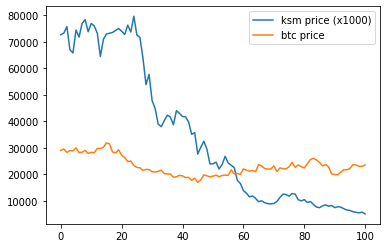

In [7]:
plt.plot([price * 1000 for price in worst_ksm_price_trajectory])
plt.plot(correlated_btc_price_trajectory)
plt.legend(["ksm price (x1000)", "btc price"])